Coeficientes originais: a1 = -0.9000, a2 = 0.8100
Polos originais: 0.4500+0.7794j e 0.4500-0.7794j

Coeficientes quantizados (N=3): a1 = -0.8750, a2 = 0.7500
Polos após quantização: 0.4375+0.7474j e 0.4375-0.7474j
Bits usados: L = 0 (inteiros), B = 3 (fracionários)

Deslocamento do polo: 0.0344


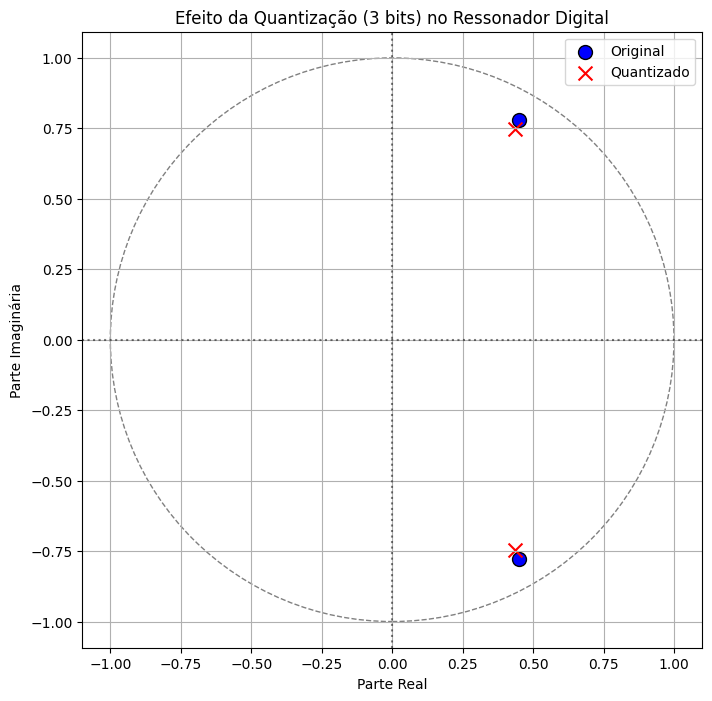

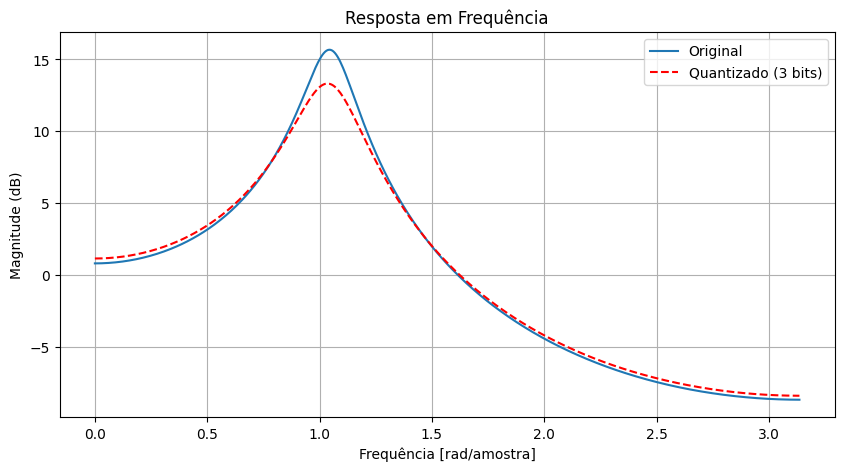

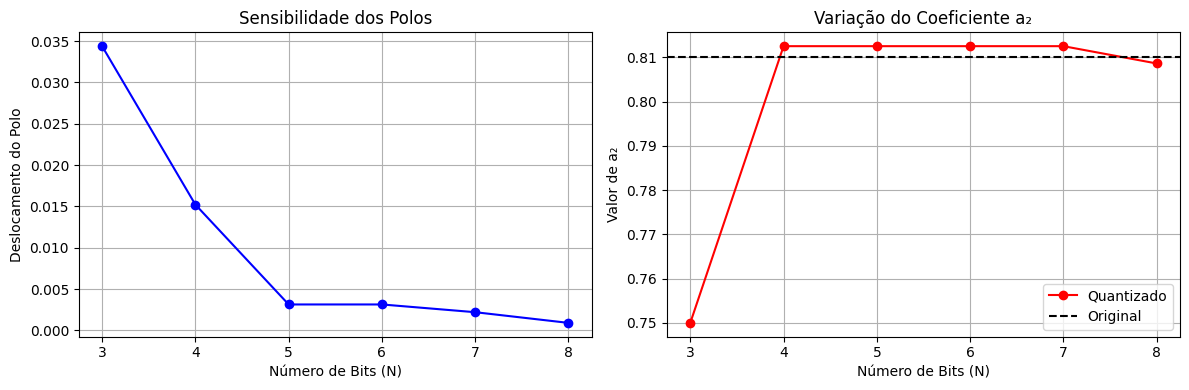

Coeficientes originais (a): [-1.57039885  1.27561332 -0.48440337  0.07619706]

Coeficientes quantizados (N=8): [-1.5703125  1.2734375 -0.484375   0.078125 ]
Bits usados: L = 1, B = 7


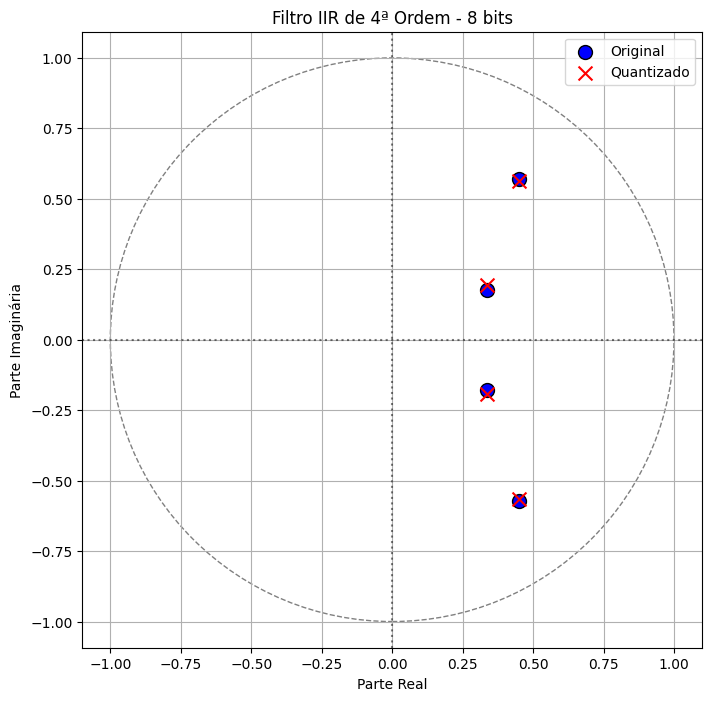

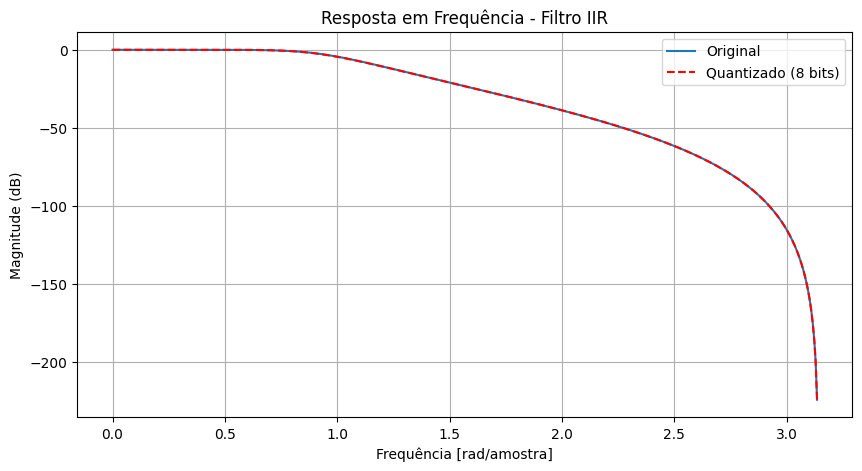

In [4]:
# # Simulação Completa: Quantização de Coeficientes em Filtros Digitais
# **Capítulo 6.8 - Digital Signal Processing Using MATLAB (3rd ed.)


# ## 1. Configuração Inicial
# Importação de bibliotecas e funções essenciais:

# %%
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import tf2zpk, freqz, zpk2tf
from matplotlib.patches import Circle


# ## 2. Funções Auxiliares


# ### 2.1 Quantização de Coeficientes
# Implementação da função `QCoeff` equivalente ao MATLAB:

# %%
def quantize_coefficients(x, N):
    """
    Quantiza coeficientes usando representação de N = 1 + L + B bits com arredondamento

    Parâmetros:
        x : array (escalar, vetor ou matriz)
        N : número total de bits (incluindo sinal)

    Retorna:
        y : array quantizado
        L : bits inteiros
        B : bits fracionários
    """
    xm = np.abs(x)
    eps = np.finfo(float).eps  # Prevenção para log(0)

    # Calcula bits inteiros necessários
    L = np.maximum(0, np.floor(np.log2(xm + eps) + 1)).astype(int)
    L = np.max(L)  # Máximo valor necessário para todo o array

    if L > N:
        raise ValueError(f'N deve ser pelo menos {L}')

    B = N - L  # Bits fracionários
    y = xm / (2**L)
    y = np.round(y * (2**N))
    y = np.sign(x) * y * (1 / (2**B)) # Changed 2**(-B) to 1 / (2**B)

    return y, L, B


# ### 2.2 Análise de Polos e Zeros
# Função para visualização do diagrama de polos e zeros:

# %%
def plot_pole_zero(poles_orig, poles_quant, title):
    plt.figure(figsize=(8,8))
    ax = plt.gca()

    # Círculo unitário
    circle = Circle((0,0), 1, fill=False, linestyle='--', color='gray')
    ax.add_patch(circle)

    # Polos originais
    plt.scatter(np.real(poles_orig), np.imag(poles_orig),
                marker='o', s=100, c='blue', label='Original', edgecolors='k')

    # Polos quantizados
    plt.scatter(np.real(poles_quant), np.imag(poles_quant),
                marker='x', s=100, c='red', label='Quantizado')

    plt.axhline(0, color='k', linestyle=':', alpha=0.5)
    plt.axvline(0, color='k', linestyle=':', alpha=0.5)
    plt.axis('equal')
    plt.grid(True)
    plt.title(title)
    plt.xlabel('Parte Real')
    plt.ylabel('Parte Imaginária')
    plt.legend()
    plt.show()


# ## 3. Exemplo 6.25: Ressonador Digital


# ### 3.1 Sistema Original
# Especificações do filtro ressonador:

# %%
# Parâmetros originais
r = 0.9                          # Raio dos polos
theta = np.pi/3                   # Ângulo (60 graus)
a1 = -2*r*np.cos(theta)           # Coeficiente a1
a2 = r**2                         # Coeficiente a2
b = [1]                           # Coeficientes do numerador
a = [1, a1, a2]                   # Coeficientes do denominador

# Polos originais
poles_orig = np.roots(a)
zeros_orig = np.roots(b)

print(f'Coeficientes originais: a1 = {a1:.4f}, a2 = {a2:.4f}')
print(f'Polos originais: {poles_orig[0]:.4f} e {poles_orig[1]:.4f}')


# ### 3.2 Quantização para 3 bits
# Aplicação da quantização nos coeficientes:

# %%
# Quantização
N_bits = 3
coeff_quant, L, B = quantize_coefficients(np.array([a1, a2]), N_bits)
a1_quant, a2_quant = coeff_quant
a_quant = [1, a1_quant, a2_quant]

# Polos após quantização
poles_quant = np.roots(a_quant)

print(f'\nCoeficientes quantizados (N={N_bits}): a1 = {a1_quant:.4f}, a2 = {a2_quant:.4f}')
print(f'Polos após quantização: {poles_quant[0]:.4f} e {poles_quant[1]:.4f}')
print(f'Bits usados: L = {L} (inteiros), B = {B} (fracionários)')

# Cálculo do deslocamento
delta_p = np.abs(poles_orig[0] - poles_quant[0])
print(f'\nDeslocamento do polo: {delta_p:.4f}')


# ### 3.3 Visualização dos Efeitos

# %%
# Diagrama de polos e zeros
plot_pole_zero(poles_orig, poles_quant,
              f'Efeito da Quantização ({N_bits} bits) no Ressonador Digital')

# Resposta em frequência
w, h_orig = freqz(b, a)
_, h_quant = freqz(b, a_quant)

plt.figure(figsize=(10,5))
plt.plot(w, 20*np.log10(np.abs(h_orig)), label='Original')
plt.plot(w, 20*np.log10(np.abs(h_quant)), 'r--', label=f'Quantizado ({N_bits} bits)')
plt.title('Resposta em Frequência')
plt.xlabel('Frequência [rad/amostra]')
plt.ylabel('Magnitude (dB)')
plt.legend()
plt.grid()
plt.show()


# ## 4. Análise de Sensibilidade para Diferentes Precisões


# ### 4.1 Variação com Número de Bits

# %%
bit_range = range(3, 9)  # De 3 a 8 bits
delta_poles = []
a2_values = []

for N in bit_range:
    coeff_quant, _, _ = quantize_coefficients(np.array([a1, a2]), N)
    a1_q, a2_q = coeff_quant
    poles_q = np.roots([1, a1_q, a2_q])
    delta = np.abs(poles_orig[0] - poles_q[0])
    delta_poles.append(delta)
    a2_values.append(a2_q)

# Gráfico de sensibilidade
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(bit_range, delta_poles, 'bo-')
plt.xlabel('Número de Bits (N)')
plt.ylabel('Deslocamento do Polo')
plt.title('Sensibilidade dos Polos')
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(bit_range, a2_values, 'ro-', label='Quantizado')
plt.axhline(a2, color='k', linestyle='--', label='Original')
plt.xlabel('Número de Bits (N)')
plt.ylabel('Valor de a₂')
plt.title('Variação do Coeficiente a₂')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# ## 5. Caso de Estudo: Filtro IIR de 4ª Ordem


# ### 5.1 Projeto do Filtro Original

# %%
from scipy.signal import butter

# Projeto do filtro Butterworth
b, a = butter(4, 0.3)  # Filtro passa-baixas, fc = 0.3*(fs/2)

# Polos e zeros originais
z, p, k = tf2zpk(b, a)

print('Coeficientes originais (a):', a[1:5])


# ### 5.2 Quantização para 8 bits

# %%
N_bits = 8
a_quant, L, B = quantize_coefficients(a[1:], N_bits)
a_quant_full = np.concatenate(([1], a_quant))

# Polos após quantização
_, p_quant, _ = tf2zpk(b, a_quant_full)

print(f'\nCoeficientes quantizados (N={N_bits}):', a_quant)
print(f'Bits usados: L = {L}, B = {B}')


# ### 5.3 Visualização Comparativa

# %%
plot_pole_zero(p, p_quant, f'Filtro IIR de 4ª Ordem - {N_bits} bits')

# Resposta em frequência
w, h_orig = freqz(b, a)
_, h_quant = freqz(b, a_quant_full)

plt.figure(figsize=(10,5))
plt.plot(w, 20*np.log10(np.abs(h_orig)), label='Original')
plt.plot(w, 20*np.log10(np.abs(h_quant)), 'r--', label=f'Quantizado ({N_bits} bits)')
plt.title('Resposta em Frequência - Filtro IIR')
plt.xlabel('Frequência [rad/amostra]')
plt.ylabel('Magnitude (dB)')
plt.legend()
plt.grid()
plt.show()